# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project Writeup: Build a Traffic Sign Recognition Classifier

The goals / steps of this project are the following:
* Load the data set (see below for links to the project data set)
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report


[//]: # (Image References)

[image1]: ./examples/visualization.jpg "Visualization"
[image2]: ./examples/grayscale.jpg "Grayscaling"
[image3]: ./examples/random_noise.jpg "Random Noise"

[image4]: ./test_images/1.jpg "Traffic Sign 1"
[image5]: ./test_images/2.jpg "Traffic Sign 2"
[image6]: ./test_images/3.jpg "Traffic Sign 3"
[image7]: ./test_images/4.jpg "Traffic Sign 4"
[image8]: ./test_images/5.jpg "Traffic Sign 5"


## Rubric Points
### Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/481/view) individually and describe how I addressed each point in my implementation.  

---
## Step 0: Load The Data

In addition to the main datasets, I also loaded the signnames.csv file as a dictionary for looking up label numbers later.

In [1]:
# Load pickled data
import pickle
import numpy as np

label_lookup = {}

label_csv = open('signnames.csv', 'r')
for line in label_csv:
    splitted = line.split(',')
    label_lookup[splitted[0]] = splitted[1][:-1] #removes \n character
label_csv.close()

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Q1. Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

I didn't use Numpy or Pandas for pulling any information about the dataset since, as I found out, all the required information was already encoded in the lengths of various subarrays.

In [2]:
# Number of training examples
n_train = len(train['features'])

# Number of validation examples
n_validation = len(valid['features'])

# Number of testing examples.
n_test = len(test['features'])

# Shape of a traffic sign image.
image_shape = str(len(train['features'][0])) + "x" + str(len(train['features'][1]))

# Number of unique classes/labels in the dataset.
n_classes = len(label_lookup)-1 #disregard first line from csv file

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = 32x32
Number of classes = 43


### Q2. Include an exploratory visualization of the dataset

To simply "get a feel" for what the network will be trained on, I randomly pulled an example from the training set, as well as its associated label. 

Next, to find out the distributions of classes in each of the datasets, I generated a histogram which counted the frequency of labels in each of the training, validation, and test sets. 

One thing that's quite apparent is that there is significantly more data available for the labels that are numerically lower. My immediate guess would be that those signs are simply more common than the others—the lower numbers include speed limit signs, which (intuitively) could be of the more common road signs.

The important part is that the distribution is *generally* similar across the three datasets, and that should ensure training accuracy.

14
Stop


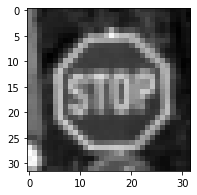

In [57]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(3,3))
plt.imshow(image, cmap="gray")
label_num = y_train[index]
print(label_num)
print(label_lookup[str(label_num)])

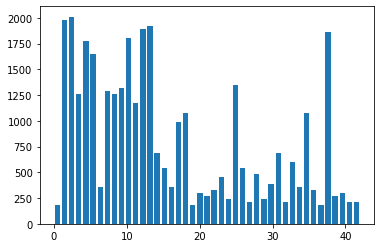

In [88]:
# Training set
hist, bins = np.histogram(y_train, bins=n_classes)

width = (bins[1] - bins[0])*0.75
center = (bins[:-1] + bins[1:])/2

plt.bar(center, hist, align='center', width=width)
plt.show()

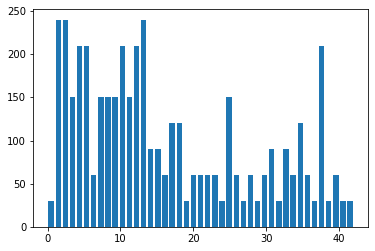

In [89]:
# Validation set
hist, bins = np.histogram(y_valid, bins=n_classes)

width = (bins[1] - bins[0])*0.75
center = (bins[:-1] + bins[1:])/2

plt.bar(center, hist, align='center', width=width)
plt.show()

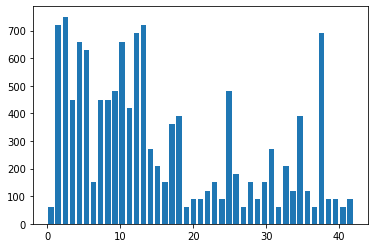

In [90]:
#Test set
hist, bins = np.histogram(y_test, bins=n_classes)

width = (bins[1] - bins[0])*0.75
center = (bins[:-1] + bins[1:])/2

plt.bar(center, hist, align='center', width=width)
plt.show()

----

## Step 2: Design and Test a Model Architecture

### Q3. Pre-process the Data Set (normalization, grayscale, etc.)

To preprocess the data, I first shuffled the training set so that the network is not trained on the *order* of the data. Next, I converted all of the images to grayscale by taking the mean of the RGB channels. Finally, I normalized the data using the given technique to bring the pixel values between -1 and 1.

In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_train = np.mean(X_train, axis=3, keepdims=True)
X_valid = np.mean(X_valid, axis=3, keepdims=True)
X_test = np.mean(X_test, axis=3, keepdims=True)

X_train = (X_train-128)/128
X_valid = (X_valid-128)/128
X_test = (X_test-128)/128

### Model Architecture

I began by using the original LeNet-5 architecture from lecture and only achieved a validation set accuracy of 86%. I decided to play around a bit and added another fully connected layer between the two existing ones with the same number of inputs and outputs (84). This resulted in a validation set accuracy of 88%: an improvement of 2%, or 88 examples out of the validation set size of 4410.

Applying the concepts from the linked Sermanet/LeCun paper significantly improved performance of the network. I was able to achieve a validation set accuracy of over 97% and a test set accuracy of over 95%. During the tuning process, I set the number of epochs absurdly high (500 at times) to analyze the behavior far beyond initial convergence. One thing that I noticed was that the accuracy jumped all over the place as it was converging, and beyond. To solve this, I switched to Leaky ReLU activations for all of the non-linear layers. Convergence noise was significantly reduced.

As an added challenge, I attempted to incorporate an inception module in the second layer by passing the inputs through a 3x3 convolution in addition to the original 5x5, and concatenating the outputs to be sent through the rest of the network. Needless to say, the number of parameters increased significantly because of the "branch and merge" step later in the network. There was an improvement in the validation set accuracy of 0.2%, but no change to the test set accuracy. It did, however, take a **lot** more time to train and evaluate. Oh well...

#### Here's the architecture of the final model ("Attempt 3" below):

0\. Input (32x32x1 images) 

---

1\. (a) Convolutional. 5x5, 1x1 stride. Input = 32x32x1. Output = 28x28x6

1\. (b) Leaky ReLU activation

1\. (c) Max pooling. 2x2, 2x2 stride. Input = 28x28x6. Output = 14x14x6.

---
2\. (a) Convolutional. 5x5, 1x1 stride, Input = 14x14x6 Output = 10x10x16.

2\. (b) Leaky ReLU activation

2\. (c) Max pooling. 2x2, 2x2 stride. Input = 10x10x16. Output = 5x5x16.

---
3\. Flatten layer 2 and branch

---
4\. (a) Convolutional. 5x5, 1x1 stride. Input = 5x5x16. Output = 1x1x400.

4\. (b) Leaky ReLU activation

---
5\. (a) Flatten layer 4 and stack with output of step 3. Output = 1x1x800.

5\. (b) Dropout layer

---
6\. (a) Fully-connected. Input = 800. Output = 120.

6\. (b) Leaky ReLU activation

6\. (c) Dropout layer

---
7\. (a) Fully-connected. Input = 120. Output = 84.

7\. (b) Leaky ReLU activation

7\. (c) Dropout layer

---
8\. (a) Fully-connected. Input = 84. Output = 43.

8\. (b) Logit output



#### Attempt 1: Original LeNet-5 from Lab. 
##### Max validation accuracy = 86%

In [92]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet5(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


#### Attempt 2: Added another fully-connected layer and called it LeNet-6.
##### Max validation accuracy = 88%

In [ ]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet6(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 84.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 84), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(84))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    
    # Layer 6: Fully Connected. Input = 84. Output = 43.    
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits


#### Attempt 3: Implemented the branching scheme from the Sermanet/LeCun paper and used Leaky ReLU activations. 

[Link to the paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).
##### Max validation accuracy = 97.4%, Test accuracy  = 95.4% (Best so far)

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def LeNet6v2(x):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.leaky_relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.leaky_relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # Branch off bypass. Input = 5x5x16. Output = 400.
    bypBranch = flatten(conv2)
    
    # Main feedforward path
    # Layer 3: Convolutional. Input = 5x5x16. Output = 1x1x400.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation
    conv3 = tf.nn.leaky_relu(conv3)
    
    # Merge branches. Output = 800.
    mainBranch = flatten(conv3)
    fc0 = tf.concat([mainBranch, bypBranch], 1)
    
    fc0 = tf.nn.dropout(fc0, keep_prob)

    # Layer 4: Fully Connected. Input = 800. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.leaky_relu(fc1)
    
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 5: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.leaky_relu(fc2)
    
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 6: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


#### Attempt 4: Added inception on the second convolution layer just for fun.
##### Max validation accuracy = 97.6%, Test accuracy = 95.4%, but training was noticeably slower.

In [87]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeCeption(x):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.leaky_relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2_1: Convolutional (Inception 1). Input = 14x14x6. Output = 10x10x16.
    conv21_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv21_b = tf.Variable(tf.zeros(16))
    conv21   = tf.nn.conv2d(conv1, conv21_W, strides=[1, 1, 1, 1], padding='VALID') + conv21_b
    
    # Layer 2_2: Convolutional (Inception 2). Input = 14x14x6. Output = 12x12x16.
    conv22_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean = mu, stddev = sigma))
    conv22_b = tf.Variable(tf.zeros(16))
    conv22   = tf.nn.conv2d(conv1, conv22_W, strides=[1, 1, 1, 1], padding='VALID') + conv22_b
    
    # Layer 2_2: Double Max Pool. Input = 12x12x16. Output = 10x10x16
    conv22 = tf.nn.max_pool(conv22, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')
    conv22 = tf.nn.max_pool(conv22, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')
    
    # Inception Stack. Output = 10x10x32
    conv2 = tf.concat((conv21, conv22), 3)
    
    # Activation.
    conv2 = tf.nn.leaky_relu(conv2)

    # Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # Branch off bypass. Input = 5x5x32. Output = 800.
    bypBranch = flatten(conv2)
    
    # Main feedforward path
    # Layer 3: Convolutional. Input = 5x5x32. Output = 1x1x800.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 800), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(800))
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation
    conv3 = tf.nn.leaky_relu(conv3)
    
    # Merge branches. Output = 1600.
    mainBranch = flatten(conv3)
    fc0 = tf.concat([mainBranch, bypBranch], 1)
    
    fc0 = tf.nn.dropout(fc0, keep_prob)

    # Layer 4: Fully Connected. Input = 1600. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation.
    fc1    = tf.nn.leaky_relu(fc1)
    
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 400. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.leaky_relu(fc2)
    
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 6: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### Train, Validate and Test the Model

I trained the model using the training set for 50 epochs, evaluating it on the validation set on each one. I plotted the validation set accuracy on a plot at the bottom of this code block. It converges at approximately 97% accuracy, with a maximum of 97.4% attained at epoch 48. I used a learning rate of 0.0007 and a batch size of 96. 

Training...

EPOCH 1 ...
Validation Accuracy = 0.7190

EPOCH 2 ...
Validation Accuracy = 0.8492

EPOCH 3 ...
Validation Accuracy = 0.8896

EPOCH 4 ...
Validation Accuracy = 0.9138

EPOCH 5 ...
Validation Accuracy = 0.9345

EPOCH 6 ...
Validation Accuracy = 0.9415

EPOCH 7 ...
Validation Accuracy = 0.9429

EPOCH 8 ...
Validation Accuracy = 0.9415

EPOCH 9 ...
Validation Accuracy = 0.9440

EPOCH 10 ...
Validation Accuracy = 0.9517

EPOCH 11 ...
Validation Accuracy = 0.9488

EPOCH 12 ...
Validation Accuracy = 0.9483

EPOCH 13 ...
Validation Accuracy = 0.9560

EPOCH 14 ...
Validation Accuracy = 0.9551

EPOCH 15 ...
Validation Accuracy = 0.9574

EPOCH 16 ...
Validation Accuracy = 0.9619

EPOCH 17 ...
Validation Accuracy = 0.9639

EPOCH 18 ...
Validation Accuracy = 0.9558

EPOCH 19 ...
Validation Accuracy = 0.9592

EPOCH 20 ...
Validation Accuracy = 0.9655

EPOCH 21 ...
Validation Accuracy = 0.9639

EPOCH 22 ...
Validation Accuracy = 0.9590

EPOCH 23 ...
Validation Accuracy = 0.9621

EPOCH 2

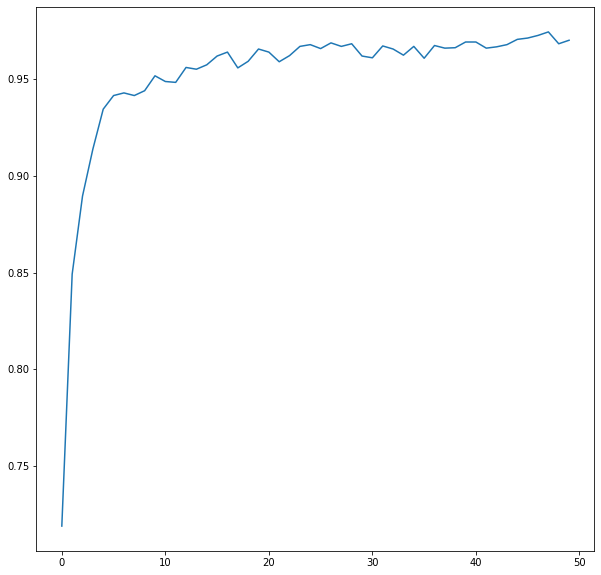

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

rate = 0.0007
EPOCHS = 50
BATCH_SIZE = 96

logits = LeNet6v2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

plot_x = []
plot_y = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        #train_accuracy = evaluate(X_train, y_train)
        plot_x.append(i)
        plot_y.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.4f}".format(validation_accuracy))
        #print("Training Accuracy = {:.4f}".format(train_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    plt.figure(figsize=(10,10))
    plt.plot(plot_x, plot_y)
    plt.show()

### Run on test set

In [66]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.954


---

## Step 3: Test a Model on New Images

Picked out random images from Google and cropped them into a square and scaled them down to be 32x32. Converted to grayscale in the code block below.

### Load and Output the Images

(5, 32, 32, 1)


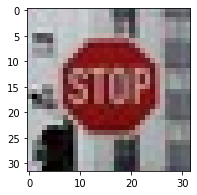

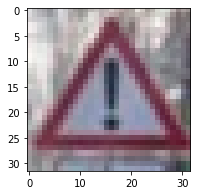

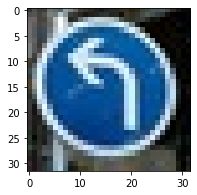

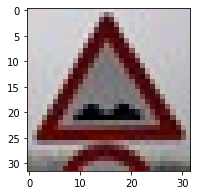

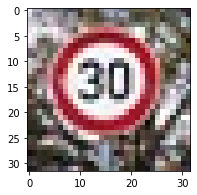

In [67]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import glob
import cv2

names = glob.glob('test_images/*.jpg')

test_imgs = []
test_imgs_color = []

for fname in names:
    new_img = mpimg.imread(fname)
    test_imgs_color.append(new_img)
    
    grey = np.mean(new_img, axis=2, keepdims=True)
    test_imgs.append(grey)
    
    plt.figure(figsize=(3,3))
    plt.imshow(new_img)

test_arr = np.asarray(test_imgs)
print(test_arr.shape)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

## Evaluation of Model Performance

I fed the model into the following code block, along with the 5 test images found online. I used the tf.nn.top_k function to output the top 5 softmax probabilities and the results were unexpectedly accurate. Not only did the model classify each sign correctly, it did so **with a 100% probability for each one**. Of course, extending to thousands more examples will begin to expose errors in the classifier, but this was completely unexpected, to say the least. Perhaps the images I picked were quite clear, and that passing in images taken in sub-optimal conditions might cause classification errors, but that could be a future test to be done.

Therefore, the top 5 output array information is patently useless after the main prediction, since it appears to just output the first 4 labels in the softmax layer with exactly 0.0% probability. I'm assuming this is some type of tie-breaker for equal probabilities.

In [87]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my = sess.run(softmax_logits, feed_dict={x: test_arr, keep_prob: 1.0})
    topkvals = sess.run(top_k, feed_dict={x: test_arr, keep_prob: 1.0})
    
    #print(topkvals.values)
    for imageidx in range(len(topkvals.indices)):
        print("Image #", imageidx+1)
        for pred_idx in range(len(topkvals.indices[imageidx])):   
            print(topkvals.indices[imageidx][pred_idx], ":", label_lookup[str(topkvals.indices[imageidx][pred_idx])], "with", topkvals.values[imageidx][pred_idx]*100, "% probability")
        print()
        

INFO:tensorflow:Restoring parameters from ./lenet
Image # 1
14 : Stop with 100.0 % probability
0 : Speed limit (20km/h) with 0.0 % probability
1 : Speed limit (30km/h) with 0.0 % probability
2 : Speed limit (50km/h) with 0.0 % probability
3 : Speed limit (60km/h) with 0.0 % probability

Image # 2
18 : General caution with 100.0 % probability
0 : Speed limit (20km/h) with 0.0 % probability
1 : Speed limit (30km/h) with 0.0 % probability
2 : Speed limit (50km/h) with 0.0 % probability
3 : Speed limit (60km/h) with 0.0 % probability

Image # 3
34 : Turn left ahead with 100.0 % probability
0 : Speed limit (20km/h) with 0.0 % probability
1 : Speed limit (30km/h) with 0.0 % probability
2 : Speed limit (50km/h) with 0.0 % probability
3 : Speed limit (60km/h) with 0.0 % probability

Image # 4
22 : Bumpy road with 100.0 % probability
0 : Speed limit (20km/h) with 0.0 % probability
1 : Speed limit (30km/h) with 0.0 % probability
2 : Speed limit (50km/h) with 0.0 % probability
3 : Speed limit (60